# Formula 1 Data Analysis with FastF1

This notebook demonstrates various analyses of Formula 1 data using the FastF1 library.

## Contents:
1. Data Loading & Setup
2. Driver Lap Time Analysis
3. Telemetry Analysis
4. Speed Comparison Between Drivers
5. Summary Statistics


In [1]:
# Import necessary libraries
import fastf1
from fastf1 import plotting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Enable FastF1 plotting backend for nice F1-style colors
plotting.setup_mpl()

print("Libraries imported successfully!")


Libraries imported successfully!


In [3]:
# Enable caching to speed up data loading
import os

cache_dir = 'f1_cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
    print(f"Created cache directory: {cache_dir}")

fastf1.Cache.enable_cache(cache_dir)
print("Cache enabled!")


Created cache directory: f1_cache
Cache enabled!


## 1. Load Race Session Data

Let's load data from a recent race. We'll use the 2024 Monaco Grand Prix as an example.


In [4]:
# Load the 2024 Monaco Grand Prix race session
session = fastf1.get_session(2024, 'Monaco', 'R')
session.load()

print(f"Session loaded: {session.event['EventName']}")
print(f"Date: {session.event['EventDate']}")
print(f"Circuit: {session.event['Location']}")


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cac

Session loaded: Monaco Grand Prix
Date: 2024-05-26 00:00:00
Circuit: Monaco


In [5]:
# Get all laps data
laps = session.laps
print(f"Total laps in race: {len(laps)}")
print(f"\nAvailable columns: {laps.columns.tolist()}")


Total laps in race: 1237

Available columns: ['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime', 'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason', 'FastF1Generated', 'IsAccurate']


In [6]:
# Get race results
results = session.results
print("Top 10 finishers:")
print(results[['Position', 'Abbreviation', 'TeamName', 'Points']].head(10))


Top 10 finishers:
    Position Abbreviation         TeamName  Points
16       1.0          LEC          Ferrari    25.0
81       2.0          PIA          McLaren    18.0
55       3.0          SAI          Ferrari    15.0
4        4.0          NOR          McLaren    12.0
63       5.0          RUS         Mercedes    10.0
1        6.0          VER  Red Bull Racing     8.0
44       7.0          HAM         Mercedes     7.0
22       8.0          TSU               RB     4.0
23       9.0          ALB         Williams     2.0
10      10.0          GAS           Alpine     1.0


## 2. Driver Lap Time Analysis

Let's compare lap times for the top 3 finishers throughout the race.


req            INFO 	Using cached data for driver_info


Analyzing top 3 drivers: ['LEC', 'PIA', 'SAI']


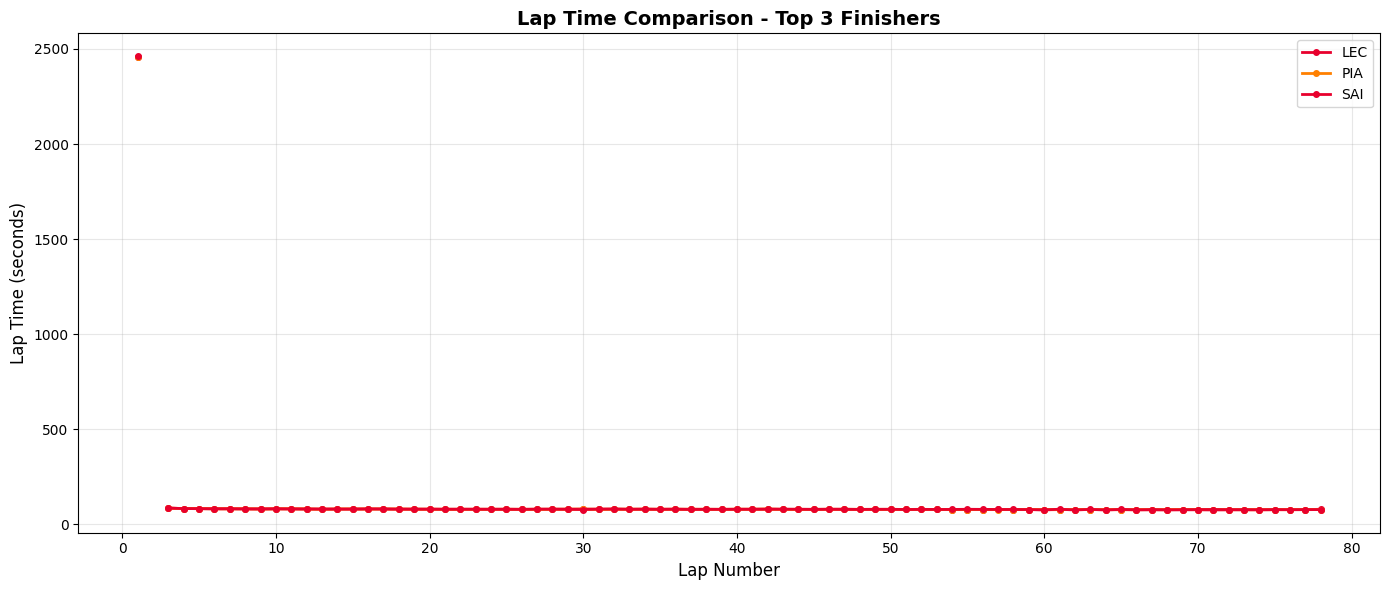

In [8]:
# Get top 3 drivers
top_3_drivers = results.head(3)['Abbreviation'].tolist()
print(f"Analyzing top 3 drivers: {top_3_drivers}")

# Plot lap times for top 3 drivers
fig, ax = plt.subplots(figsize=(14, 6))

for driver in top_3_drivers:
    driver_laps = laps.pick_driver(driver)
    # Convert lap times to seconds for easier plotting
    driver_laps['LapTime_s'] = driver_laps['LapTime'].dt.total_seconds()
    
    # Get team color for the driver
    team_color = plotting.get_driver_color(driver, session=session)
    
    ax.plot(driver_laps['LapNumber'], driver_laps['LapTime_s'], 
            marker='o', label=driver, color=team_color, linewidth=2, markersize=4)

ax.set_xlabel('Lap Number', fontsize=12)
ax.set_ylabel('Lap Time (seconds)', fontsize=12)
ax.set_title('Lap Time Comparison - Top 3 Finishers', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 3. Fastest Lap Analysis

Let's find and compare the fastest laps of different drivers.


In [9]:
# Get fastest lap for each driver
fastest_laps = []

for driver in top_3_drivers:
    driver_laps = laps.pick_driver(driver)
    fastest_lap = driver_laps.pick_fastest()
    fastest_laps.append({
        'Driver': driver,
        'LapTime': fastest_lap['LapTime'].total_seconds(),
        'LapNumber': fastest_lap['LapNumber'],
        'Compound': fastest_lap['Compound']
    })

fastest_df = pd.DataFrame(fastest_laps).sort_values('LapTime')
print("Fastest Laps Comparison:")
print(fastest_df)


Fastest Laps Comparison:
  Driver  LapTime  LapNumber Compound
2    SAI   74.726       62.0     HARD
0    LEC   75.162       71.0     HARD
1    PIA   76.281       73.0     HARD


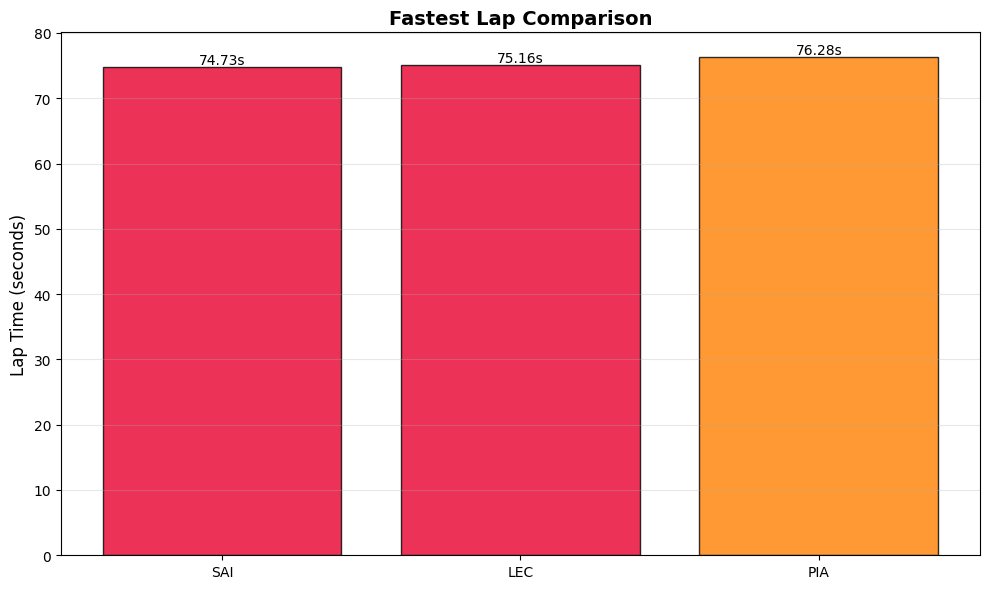

In [10]:
# Visualize fastest lap times
fig, ax = plt.subplots(figsize=(10, 6))

colors = [plotting.get_driver_color(driver, session=session) for driver in fastest_df['Driver']]
bars = ax.bar(fastest_df['Driver'], fastest_df['LapTime'], color=colors, alpha=0.8, edgecolor='black')

ax.set_ylabel('Lap Time (seconds)', fontsize=12)
ax.set_title('Fastest Lap Comparison', fontsize=14, fontweight='bold')
ax.grid(True, axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}s',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## 4. Telemetry Analysis - Speed Comparison

Let's analyze telemetry data from the fastest laps to see how speed varies around the track.


In [ ]:
t # Pick two drivers to compare (e.g., first and second place)
driver1 = top_3_drivers[0]
driver2 = top_3_drivers[1]

# Get fastest laps for both drivers
fastest_driver1 = laps.pick_driver(driver1).pick_fastest()
fastest_driver2 = laps.pick_driver(driver2).pick_fastest()

# Get telemetry data
telemetry_driver1 = fastest_driver1.get_telemetry()
telemetry_driver2 = fastest_driver2.get_telemetry()

print(f"Telemetry data loaded for {driver1} and {driver2}")
print(f"Available telemetry channels: {telemetry_driver1.columns.tolist()}")


Telemetry data loaded for LEC and PIA
Available telemetry channels: ['Date', 'SessionTime', 'DriverAhead', 'DistanceToDriverAhead', 'Time', 'RPM', 'Speed', 'nGear', 'Throttle', 'Brake', 'DRS', 'Source', 'Distance', 'RelativeDistance', 'Status', 'X', 'Y', 'Z']


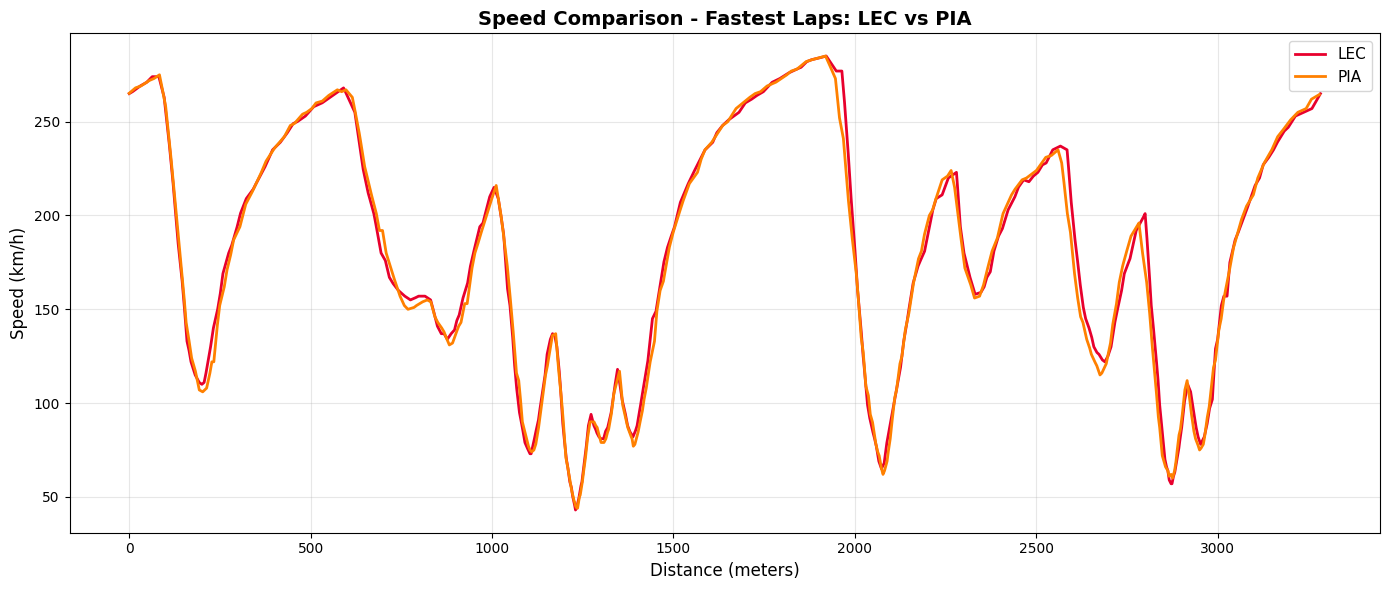

In [12]:
# Plot speed comparison
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(telemetry_driver1['Distance'], telemetry_driver1['Speed'], 
        label=driver1, color=plotting.get_driver_color(driver1, session=session), linewidth=2)
ax.plot(telemetry_driver2['Distance'], telemetry_driver2['Speed'], 
        label=driver2, color=plotting.get_driver_color(driver2, session=session), linewidth=2)

ax.set_xlabel('Distance (meters)', fontsize=12)
ax.set_ylabel('Speed (km/h)', fontsize=12)
ax.set_title(f'Speed Comparison - Fastest Laps: {driver1} vs {driver2}', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


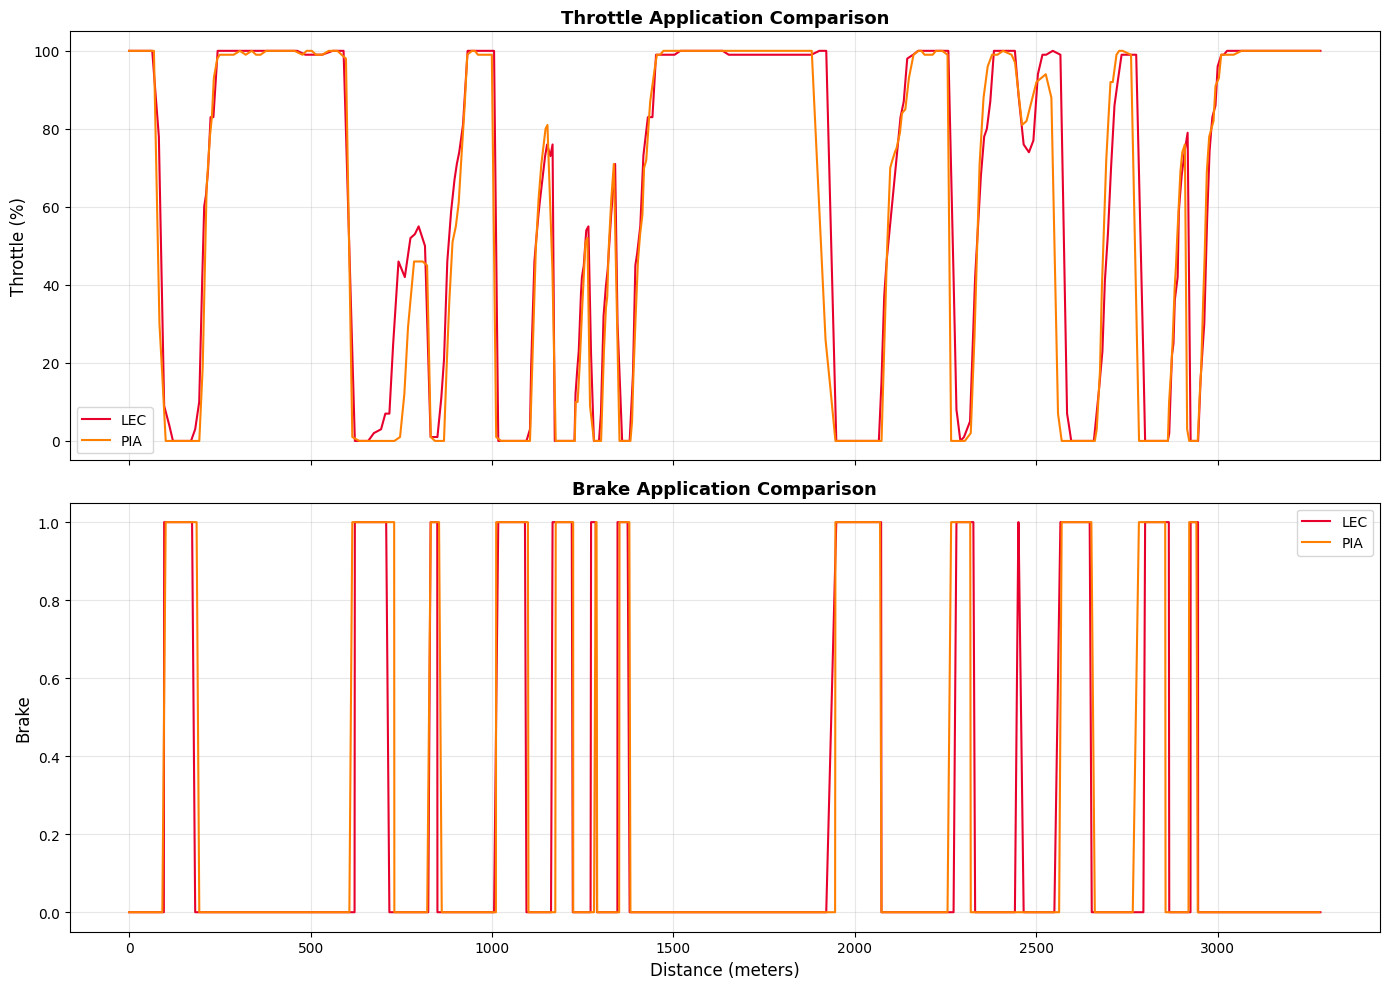

In [13]:
# Plot throttle and brake comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Throttle
ax1.plot(telemetry_driver1['Distance'], telemetry_driver1['Throttle'], 
         label=driver1, color=plotting.get_driver_color(driver1, session=session), linewidth=1.5)
ax1.plot(telemetry_driver2['Distance'], telemetry_driver2['Throttle'], 
         label=driver2, color=plotting.get_driver_color(driver2, session=session), linewidth=1.5)
ax1.set_ylabel('Throttle (%)', fontsize=12)
ax1.set_title('Throttle Application Comparison', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Brake
ax2.plot(telemetry_driver1['Distance'], telemetry_driver1['Brake'], 
         label=driver1, color=plotting.get_driver_color(driver1, session=session), linewidth=1.5)
ax2.plot(telemetry_driver2['Distance'], telemetry_driver2['Brake'], 
         label=driver2, color=plotting.get_driver_color(driver2, session=session), linewidth=1.5)
ax2.set_xlabel('Distance (meters)', fontsize=12)
ax2.set_ylabel('Brake', fontsize=12)
ax2.set_title('Brake Application Comparison', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 5. Summary Statistics

Let's compute some interesting statistics from the race.


In [14]:
# Calculate average speed for fastest laps
print("=" * 50)
print("TELEMETRY STATISTICS - FASTEST LAPS")
print("=" * 50)

for driver, telemetry in [(driver1, telemetry_driver1), (driver2, telemetry_driver2)]:
    print(f"\n{driver}:")
    print(f"  Average Speed: {telemetry['Speed'].mean():.2f} km/h")
    print(f"  Max Speed: {telemetry['Speed'].max():.2f} km/h")
    print(f"  Min Speed: {telemetry['Speed'].min():.2f} km/h")
    print(f"  Average Throttle: {telemetry['Throttle'].mean():.2f}%")
    print(f"  Time at Full Throttle: {(telemetry['Throttle'] == 100).sum() / len(telemetry) * 100:.1f}%")


TELEMETRY STATISTICS - FASTEST LAPS

LEC:
  Average Speed: 159.00 km/h
  Max Speed: 285.00 km/h
  Min Speed: 43.00 km/h
  Average Throttle: 52.88%
  Time at Full Throttle: 22.6%

PIA:
  Average Speed: 155.16 km/h
  Max Speed: 285.00 km/h
  Min Speed: 44.00 km/h
  Average Throttle: 49.48%
  Time at Full Throttle: 18.3%


In [15]:
# Calculate race statistics for all drivers
print("\n" + "=" * 50)
print("RACE STATISTICS - ALL DRIVERS")
print("=" * 50)

race_stats = []
for driver_abbr in results['Abbreviation'][:10]:  # Top 10 drivers
    driver_laps = laps.pick_driver(driver_abbr)
    if len(driver_laps) > 0:
        lap_times = driver_laps['LapTime'].dt.total_seconds()
        race_stats.append({
            'Driver': driver_abbr,
            'Total Laps': len(driver_laps),
            'Avg Lap Time': lap_times.mean(),
            'Std Lap Time': lap_times.std(),
            'Fastest Lap': lap_times.min()
        })

stats_df = pd.DataFrame(race_stats)
print("\n", stats_df.to_string(index=False))



RACE STATISTICS - ALL DRIVERS

 Driver  Total Laps  Avg Lap Time  Std Lap Time  Fastest Lap
   LEC          78    109.320740    270.991078       75.162
   PIA          78    109.436091    271.255821       76.281
   SAI          78    109.486688    271.710191       74.726
   NOR          78    109.565429    272.315026       75.742
   RUS          78    109.697364    272.977156       75.228
   VER          78    109.765766    273.561119       74.569
   HAM          78    109.839610    274.116023       74.165
   TSU          77    112.143390    274.504951       74.720
   ALB          77    112.332545    275.178094       77.060
   GAS          77    112.412922    275.493422       75.625


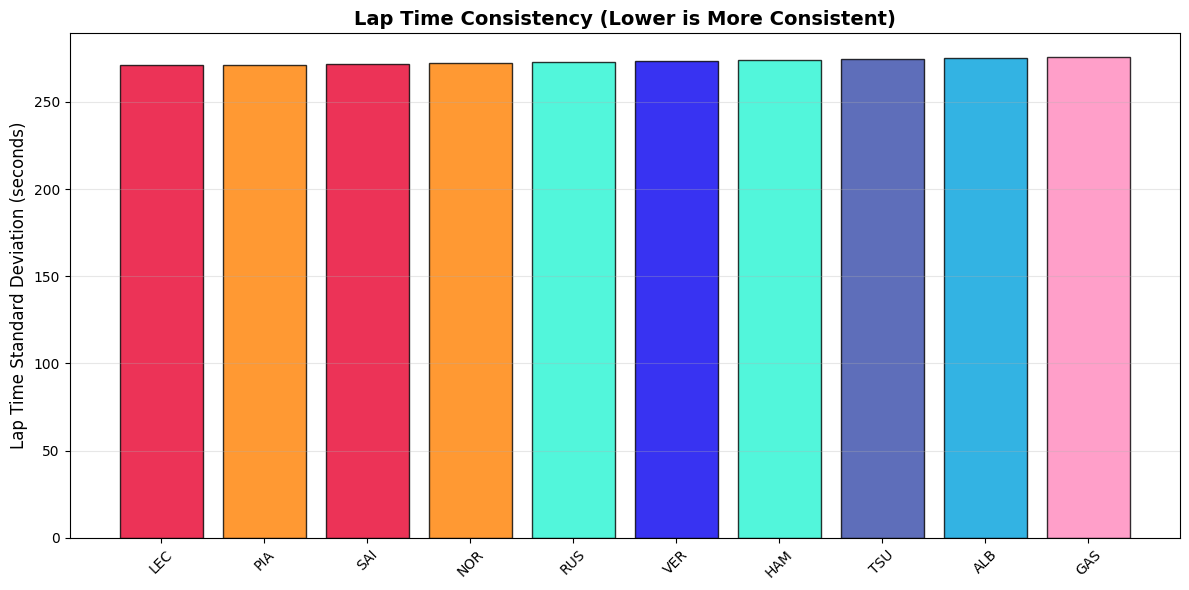

In [16]:
# Visualize lap time consistency (standard deviation)
fig, ax = plt.subplots(figsize=(12, 6))

colors = [plotting.get_driver_color(driver, session=session) for driver in stats_df['Driver']]
bars = ax.bar(stats_df['Driver'], stats_df['Std Lap Time'], color=colors, alpha=0.8, edgecolor='black')

ax.set_ylabel('Lap Time Standard Deviation (seconds)', fontsize=12)
ax.set_title('Lap Time Consistency (Lower is More Consistent)', fontsize=14, fontweight='bold')
ax.grid(True, axis='y', alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Conclusion

This notebook demonstrated various analyses possible with the FastF1 library:

1. **Lap Time Analysis**: Compared lap times throughout the race for top finishers
2. **Fastest Lap Comparison**: Identified and compared the fastest laps of different drivers
3. **Telemetry Analysis**: Examined speed, throttle, and brake application patterns
4. **Summary Statistics**: Calculated performance metrics and consistency measures

### Further Analysis Ideas:
- Tire strategy analysis (compound changes throughout the race)
- Qualifying vs Race pace comparison
- Weather impact on performance
- Track position changes over time
- Sector time analysis
- DRS usage and effectiveness
